In [1]:
from utils.self_preference_analyzer import Config, AnalyzeDataLoader, PlotUtils, QualitativeEvaluator
import matplotlib.pyplot as plt 
import pandas as pd
from typing import Dict, List, Optional, Union, Tuple
import numpy as np
import os

In [2]:
class CountryAnalyzer:
    """Class for country-based analysis and visualization."""
    
    def __init__(self, config: Config, plot_utils: PlotUtils):
        self.config = config
        self.plot_utils = plot_utils
    
    def plot_wins_by_country(self, df: pd.DataFrame, experiment_type: str = "all") -> None:
        """Plot percentage of wins by country, ordered by resource availability."""
        # Filter data by experiment type
        if experiment_type == "all":
            grouped_df = df.groupby('country')[self.config.WIN_TYPES].sum()
        else:
            filtered_df = df[df['experiment'] == experiment_type]
            grouped_df = filtered_df.groupby('country')[self.config.WIN_TYPES].sum()
        
        # Reindex by resource order and calculate percentages
        grouped_df = grouped_df.reindex(self.config.SORTED_COUNTRIES_BY_RESOURCE, fill_value=0)
        grouped_df = self.plot_utils.calculate_percentages(grouped_df, self.config.WIN_TYPES)
        
        # Create plot
        fig, ax = plt.subplots(figsize=self.config.FIGURE_SIZE)
        ax.set_ylim(0, 110)
        self.plot_utils.setup_stacked_bar_plot(
            ax, grouped_df,
            f'Percentage of Wins by Embedding Models ({experiment_type})',
            'Model', self.config.WIN_TYPES, self.config.BAR_WIDTH,
        )

        ax.set_xticklabels(grouped_df.index, rotation=90, fontsize=25)
        ax.set_xlabel('Model', fontsize=25)
        ax.set_ylabel('Percentage of Wins', fontsize=25)
        ax.set_title(f'Percentage of Wins by Embedding Models ({experiment_type})', fontsize=25)
        ax.tick_params(axis='both', which='major', labelsize=25)
        ax.legend(fontsize=25)
        plt.tight_layout()
        plt.show()
    
    def plot_wins_by_country_per_model(self, df: pd.DataFrame, experiment_type: str = "all") -> None:
        """Plot wins by country for each model separately."""
        # Filter and group data
        if experiment_type == "all":
            grouped_df = df.groupby(['country', 'model'])[self.config.WIN_TYPES].sum()
        else:
            filtered_df = df[df['experiment'] == experiment_type]
            grouped_df = filtered_df.groupby(['country', 'model'])[self.config.WIN_TYPES].sum()
        
        grouped_df = self.plot_utils.calculate_percentages(grouped_df, self.config.WIN_TYPES)
        models = grouped_df.index.get_level_values('model').unique()
        
        # Create separate plot for each model
        for model in models:
            model_df = grouped_df[grouped_df.index.get_level_values('model') == model]
            
            # Reorder by resource availability
            available_countries = [country for country in self.config.SORTED_COUNTRIES_BY_RESOURCE 
                                 if country in model_df.index.get_level_values('country')]
            model_df = model_df.reindex(available_countries, level='country')
            
            # Create plot
            fig, ax = plt.subplots(figsize=(20,7))
            self.plot_utils.setup_stacked_bar_plot(
                ax, model_df,
                f'Percentage of Wins by Country for Model: {model} ({experiment_type})',
                'Country', self.config.WIN_TYPES, self.config.BAR_WIDTH

            )
            
            ax.set_xticklabels(model_df.index.get_level_values('country'), rotation=90, fontsize=40)
            ax.set_xlabel('Country', fontsize=30)
            ax.set_ylabel('Percentage of Wins', fontsize=25)
            ax.set_title(f'Percentage of Wins by Country for Model: {model} ({experiment_type})', fontsize=35)
            ax.tick_params(axis='both', which='major', labelsize=25)
            # ax.legend(fontsize=25)
            ax.legend.remove()

            plt.tight_layout()
            plt.show()
    
    def plot_wins_grouped_by_model(self, df: pd.DataFrame, model_groups: Union[List[str], Dict[str, List[str]]], 
                                  experiment_type: str = "all") -> None:
        """Plot wins grouped by model with countries on x-axis."""
        # Handle list input for model_groups
        if isinstance(model_groups, list):
            model_groups = {model_name: [model_name] for model_name in model_groups}
        
        # Filter data
        if experiment_type not in ["all", "text-to-image", "image-to-image"]:
            raise ValueError("Invalid experiment_type. Must be 'all', 'text-to-image', or 'image-to-image'.")
        
        filtered_df = df.copy()
        if experiment_type != "all":
            filtered_df = filtered_df[filtered_df['experiment'] == experiment_type]
        
        # Filter by models
        all_models_to_plot = [model for models in model_groups.values() for model in models]
        filtered_df = filtered_df[filtered_df['model'].isin(all_models_to_plot)]
        
        if filtered_df.empty:
            print("Warning: No data found for specified models and experiment type.")
            return
        
        # Group and calculate percentages
        grouped_df = filtered_df.groupby(['country', 'model'])[self.config.WIN_TYPES].sum()
        grouped_df = self.plot_utils.calculate_percentages(grouped_df, self.config.WIN_TYPES)
        
        # Create plot for each win type
        for win_type in self.config.WIN_TYPES:
            fig, ax = plt.subplots(figsize=(25,7))
            
            # Order countries by resource availability
            available_countries = [country for country in self.config.SORTED_COUNTRIES_BY_RESOURCE
                                 if country in grouped_df.index.get_level_values('country')]
            
            # Calculate positions for bars
            n_groups = len(model_groups)
            group_width = 0.8
            bar_width = group_width / n_groups
            x = np.arange(len(available_countries))
            
            # Plot bars for each model group
            for i, (group_name, models) in enumerate(model_groups.items()):
                group_data = []
                for country in available_countries:
                    if country in grouped_df.index.get_level_values('country'):
                        country_data = grouped_df.loc[country]
                        model_values = [country_data.loc[model][f'{win_type}_percentage']
                                      for model in models if model in country_data.index]
                        group_data.append(np.mean(model_values) if model_values else 0)
                    else:
                        group_data.append(0)
                
                offset = i * bar_width - group_width/2 + bar_width/2
                bars = ax.bar(x + offset, group_data, bar_width, label=group_name)
                
                # Add data labels
                self.plot_utils.add_data_labels(ax, bars, rotation=90)
            
            ax.set_xlabel('Country', fontsize=40)
            ax.set_ylabel('Percentage of Wins', fontsize=40)
            ax.set_title(f'Percentage of {win_type} by Model Group and Country ({experiment_type})', fontsize=40)
            ax.set_xticks(x)
            ax.set_xticklabels(available_countries, rotation=45, ha='right', fontsize=40)
            ax.legend(title='Model Groups', fontsize=40, bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.set_ylim(0, 110)
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.tick_params(axis='both', which='major', labelsize=40)

            plt.tight_layout()
            plt.show()



In [3]:
config = Config()
plot_utils = PlotUtils()
country_analyzer = CountryAnalyzer(config, plot_utils)

In [4]:
# Initialize data loader
data_loader = AnalyzeDataLoader(config)
dataframes = data_loader.prepare_data()

# Extract individual dataframes for easier access
concept_df = dataframes['concept']
country_df = dataframes['country'] 
overall_df = dataframes['overall']
language_df = dataframes['language']

## Overall performance for each country

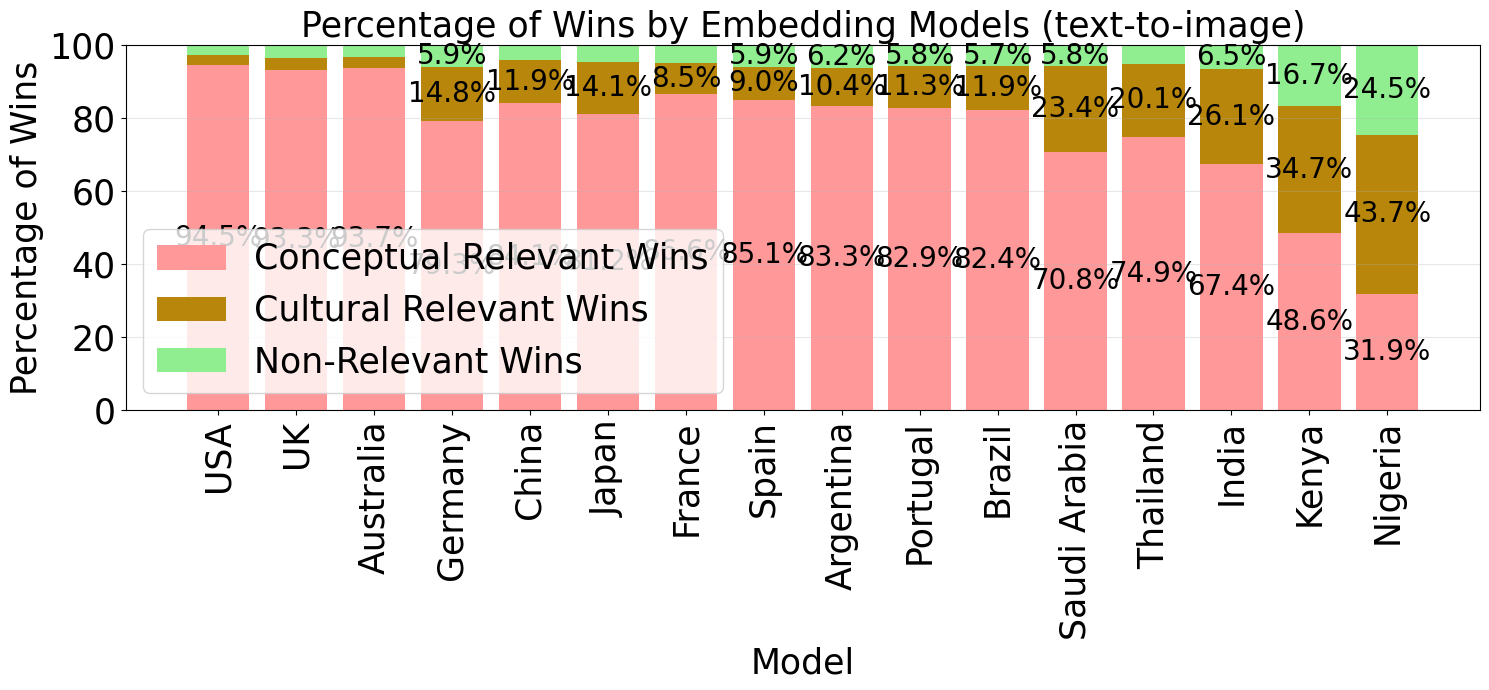

In [5]:
country_analyzer.plot_wins_by_country(country_df, 'text-to-image')

## Performance for each country on each model

AttributeError: 'function' object has no attribute 'remove'

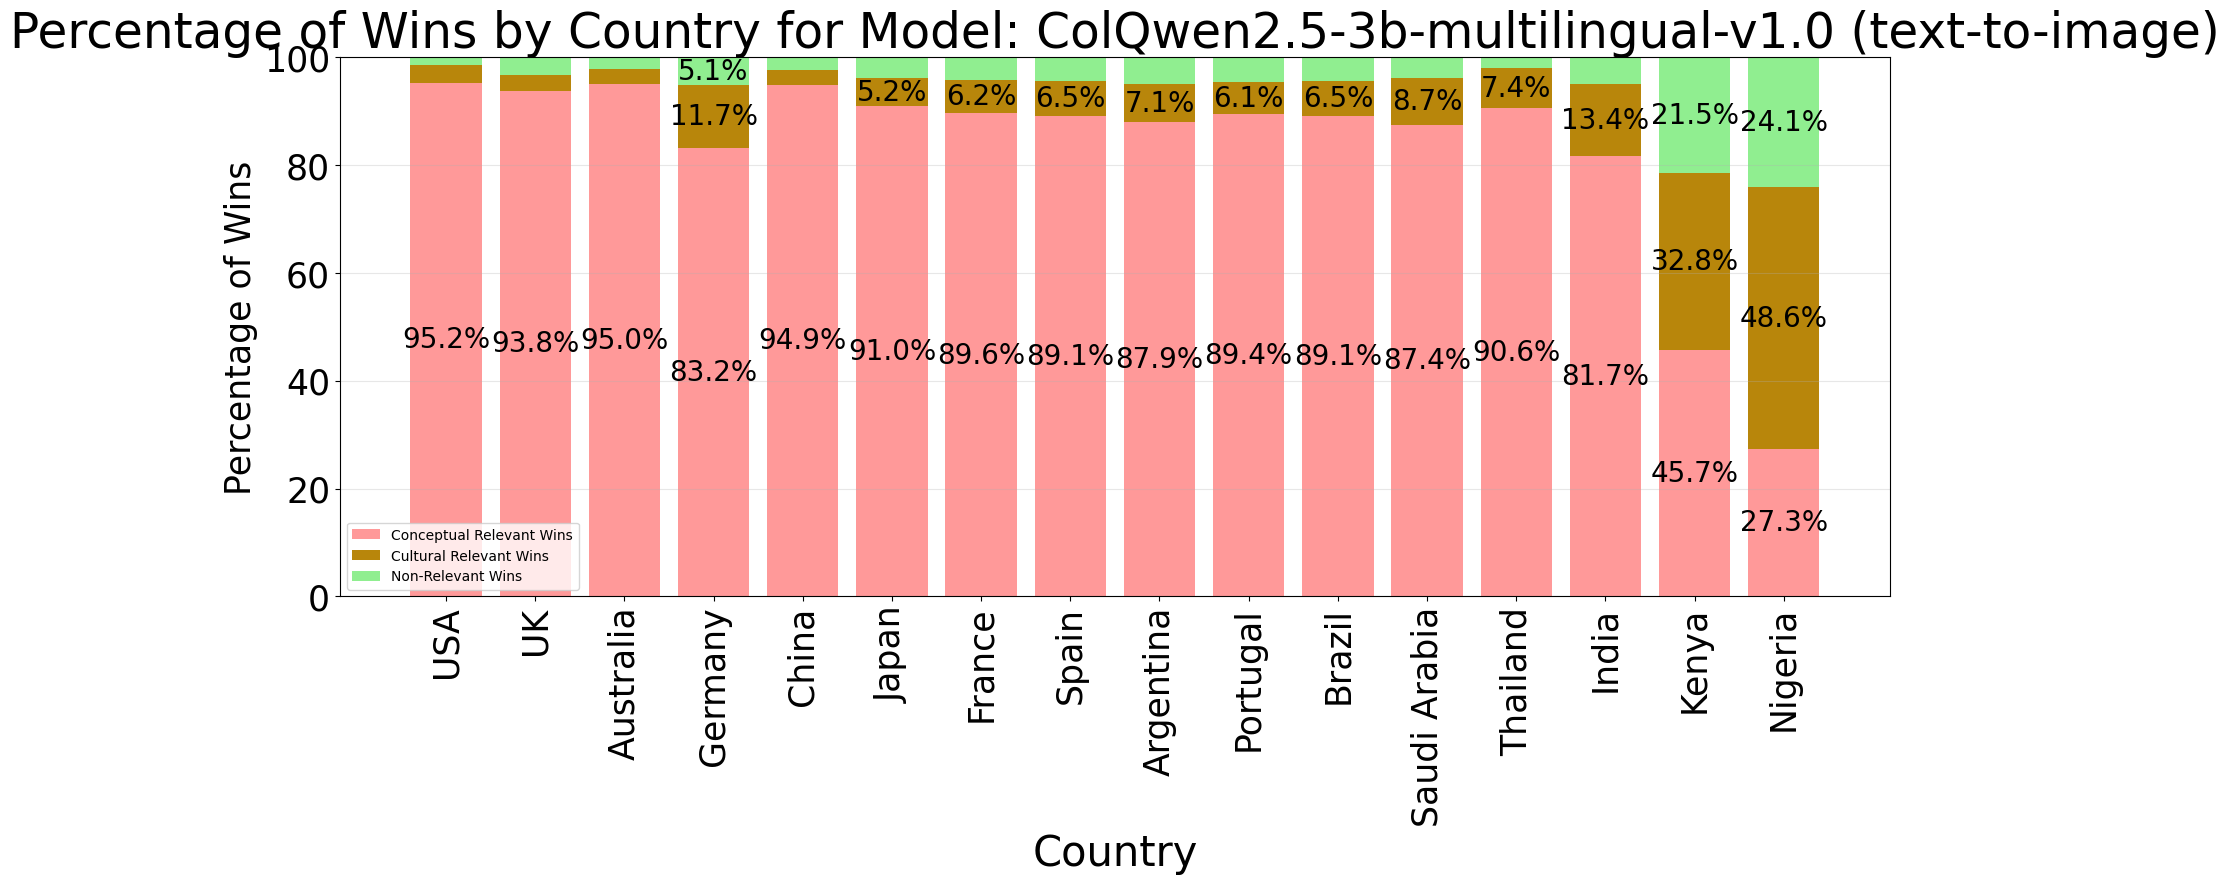

In [6]:

country_analyzer.plot_wins_by_country_per_model(country_df, 'text-to-image')

## Pretrain vs Fine-Tune

#### GME

In [ ]:
country_df['model'].unique()

array(['chinese-clip-vit-large-patch14', 'clip-ViT-B-16-plus-240',
       'clip-vit-large-patch14', 'colpali-v1.3', 'colqwen2-v1.0',
       'ColQwen2.5-3b-multilingual-v1.0',
       'ColQwen2.5-7b-multilingual-v1.0', 'colqwen2.5-v0.2',
       'gme-Qwen2-VL-2B-Instruct', 'gme-Qwen2-VL-7B-Instruct',
       'jina-embeddings-v4', 'XLM-Roberta-Large-Vit-B-16Plus',
       'XLM-Roberta-Large-Vit-B-32', 'XLM-Roberta-Large-Vit-L-14'],
      dtype=object)

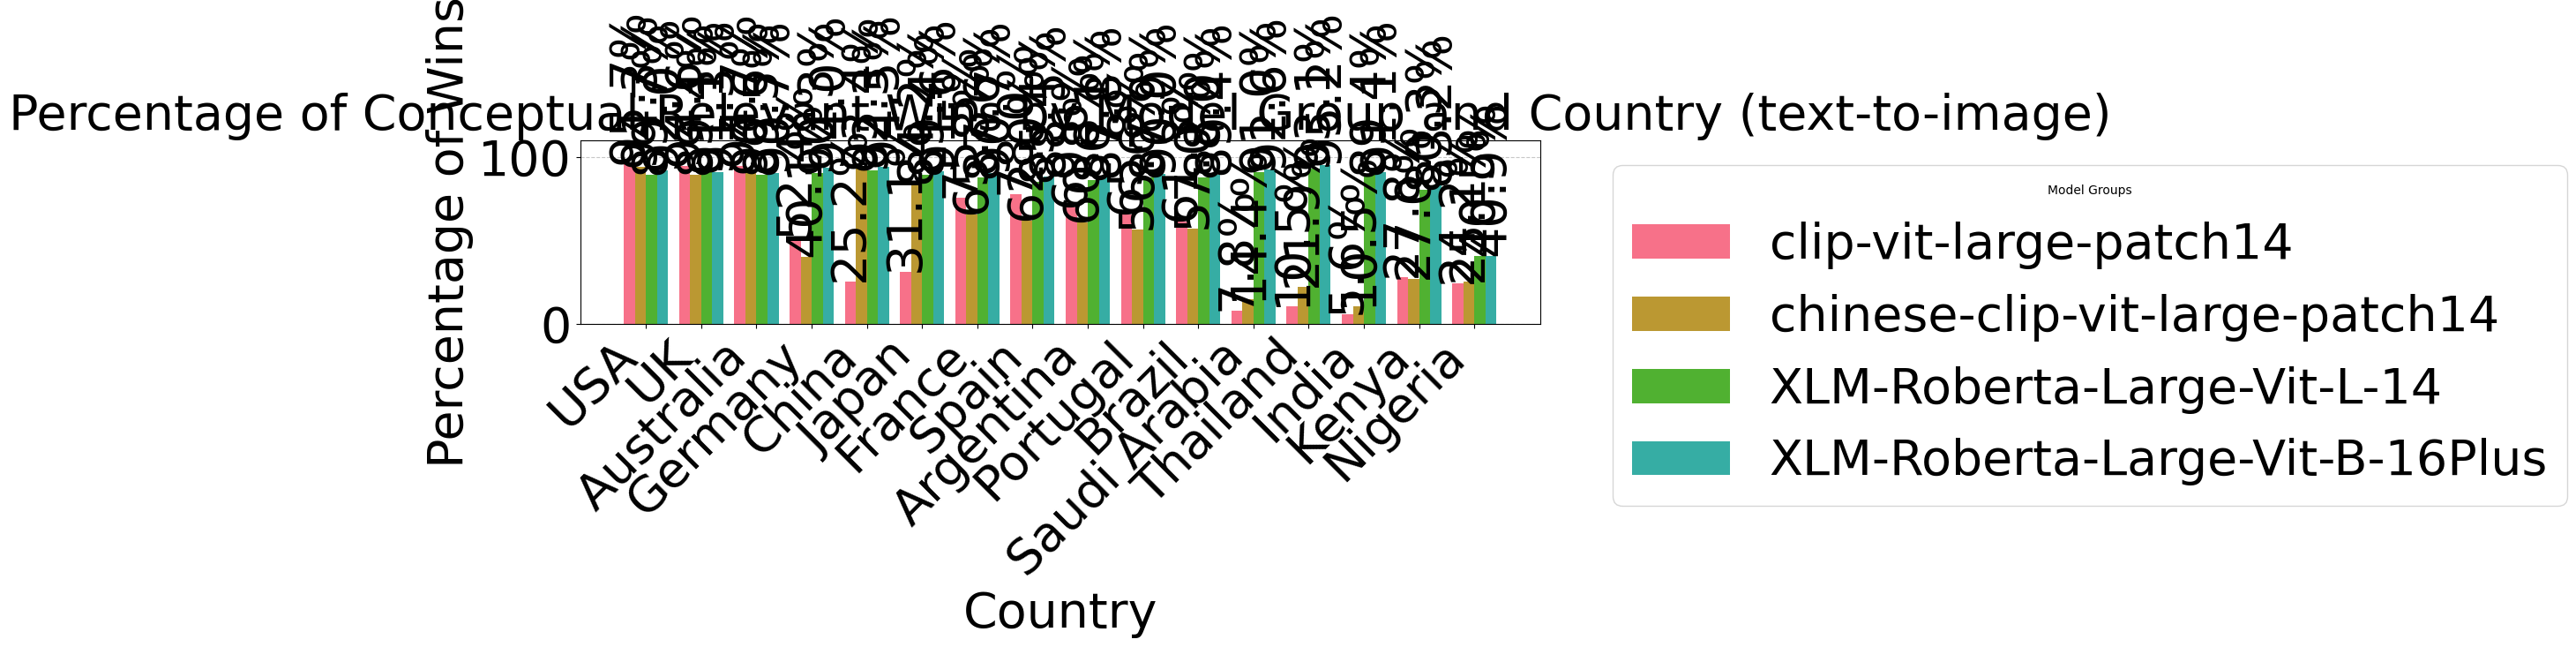

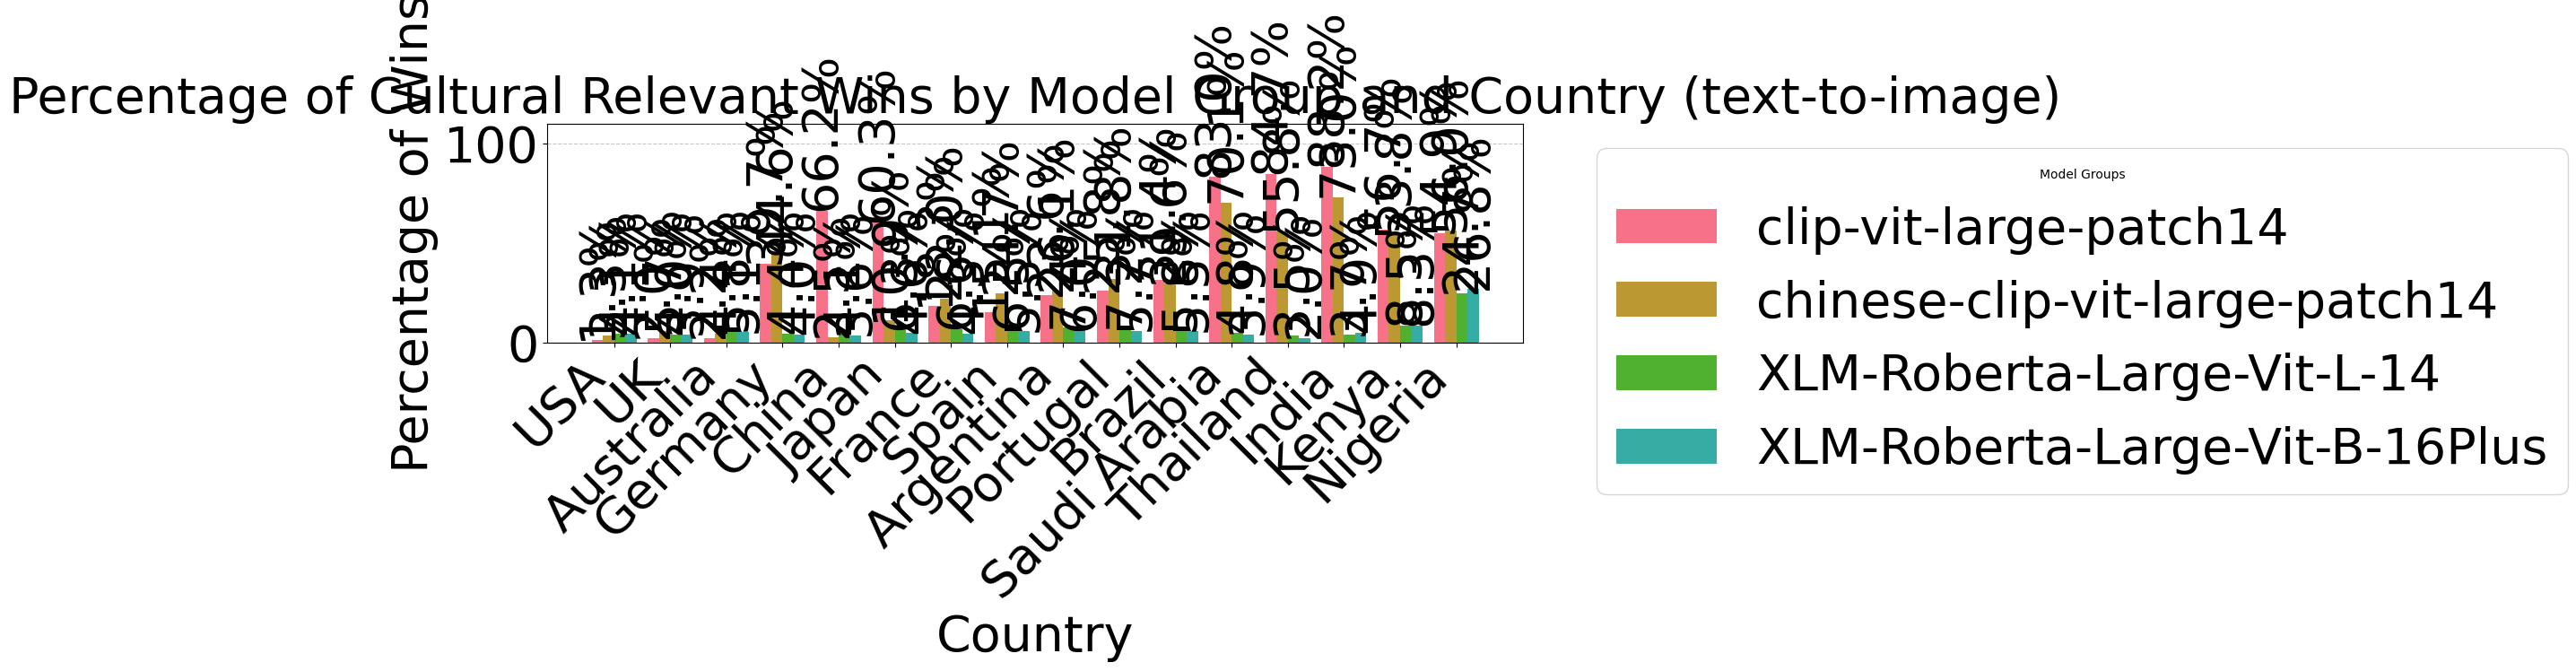

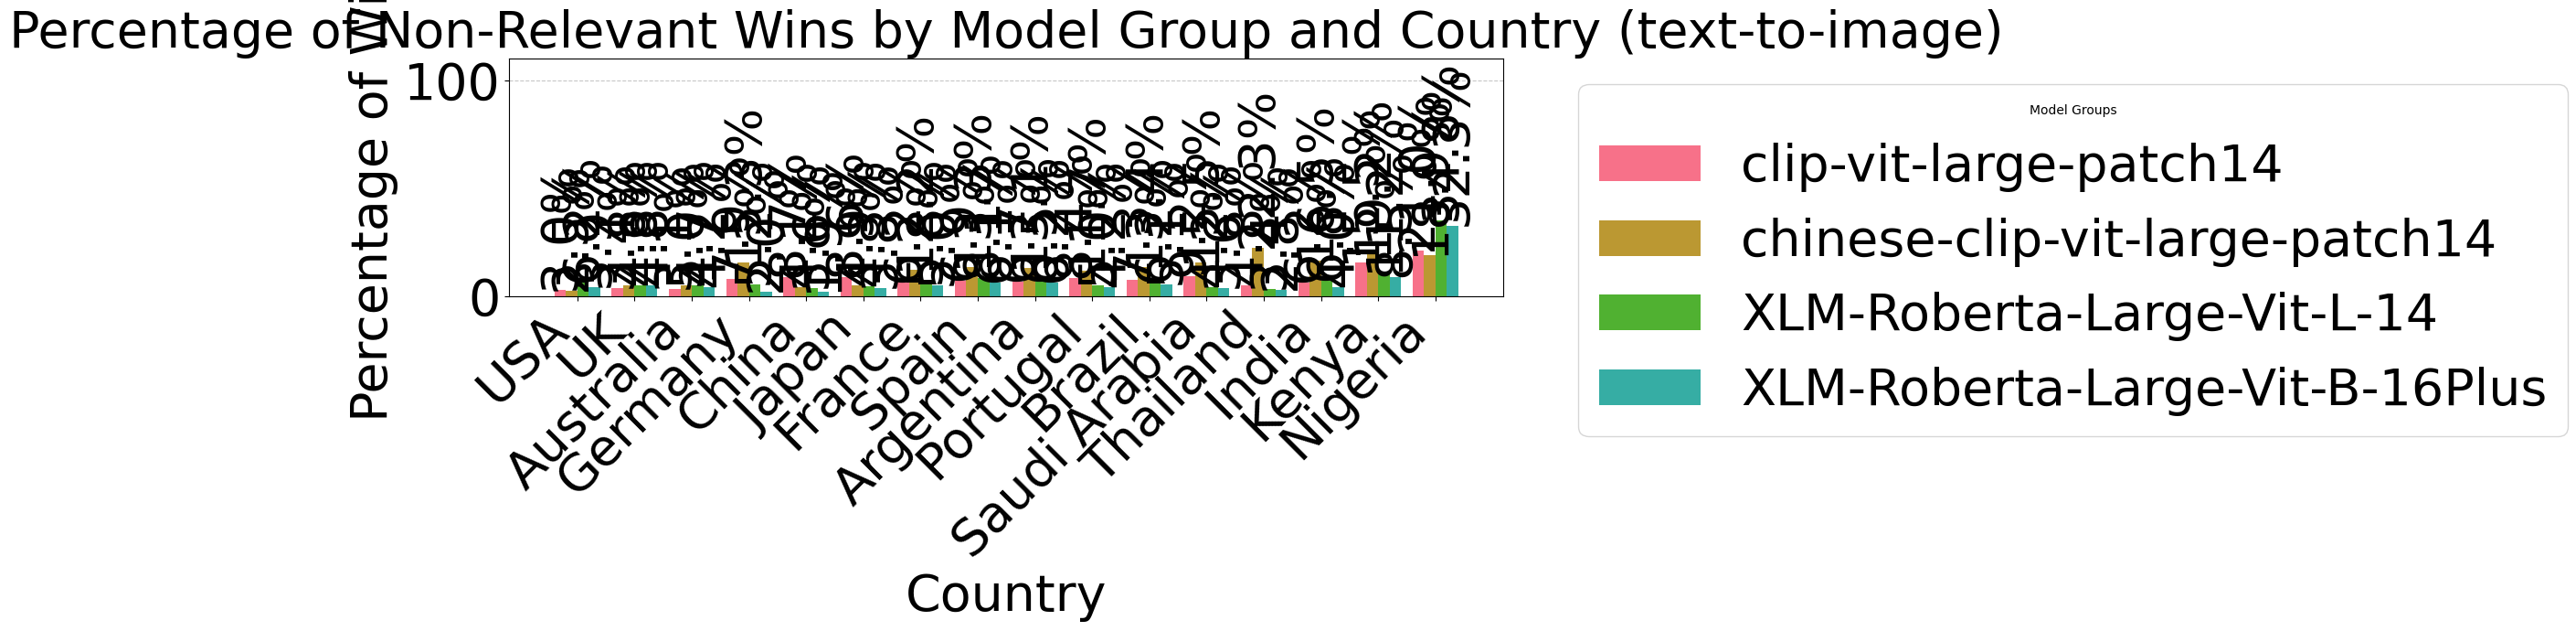

In [ ]:
country_analyzer.plot_wins_grouped_by_model(country_df, ['clip-vit-large-patch14', 'chinese-clip-vit-large-patch14', 'XLM-Roberta-Large-Vit-L-14', 'XLM-Roberta-Large-Vit-B-16Plus'], 'text-to-image')

#### CLIP

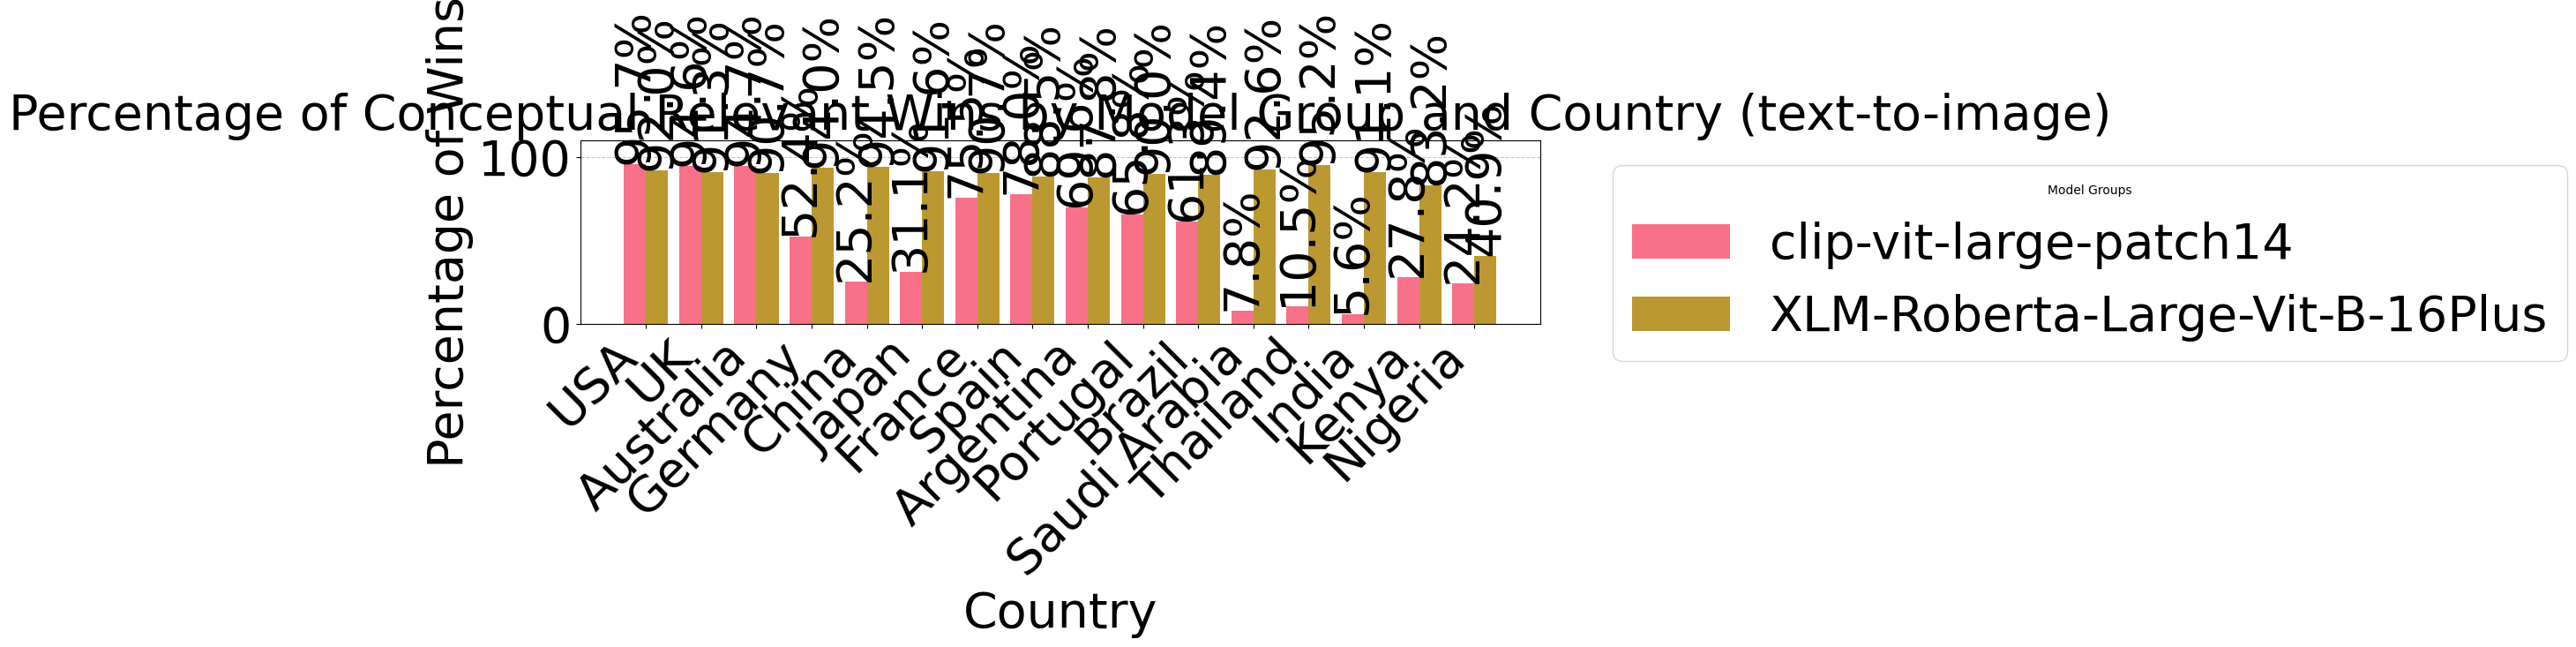

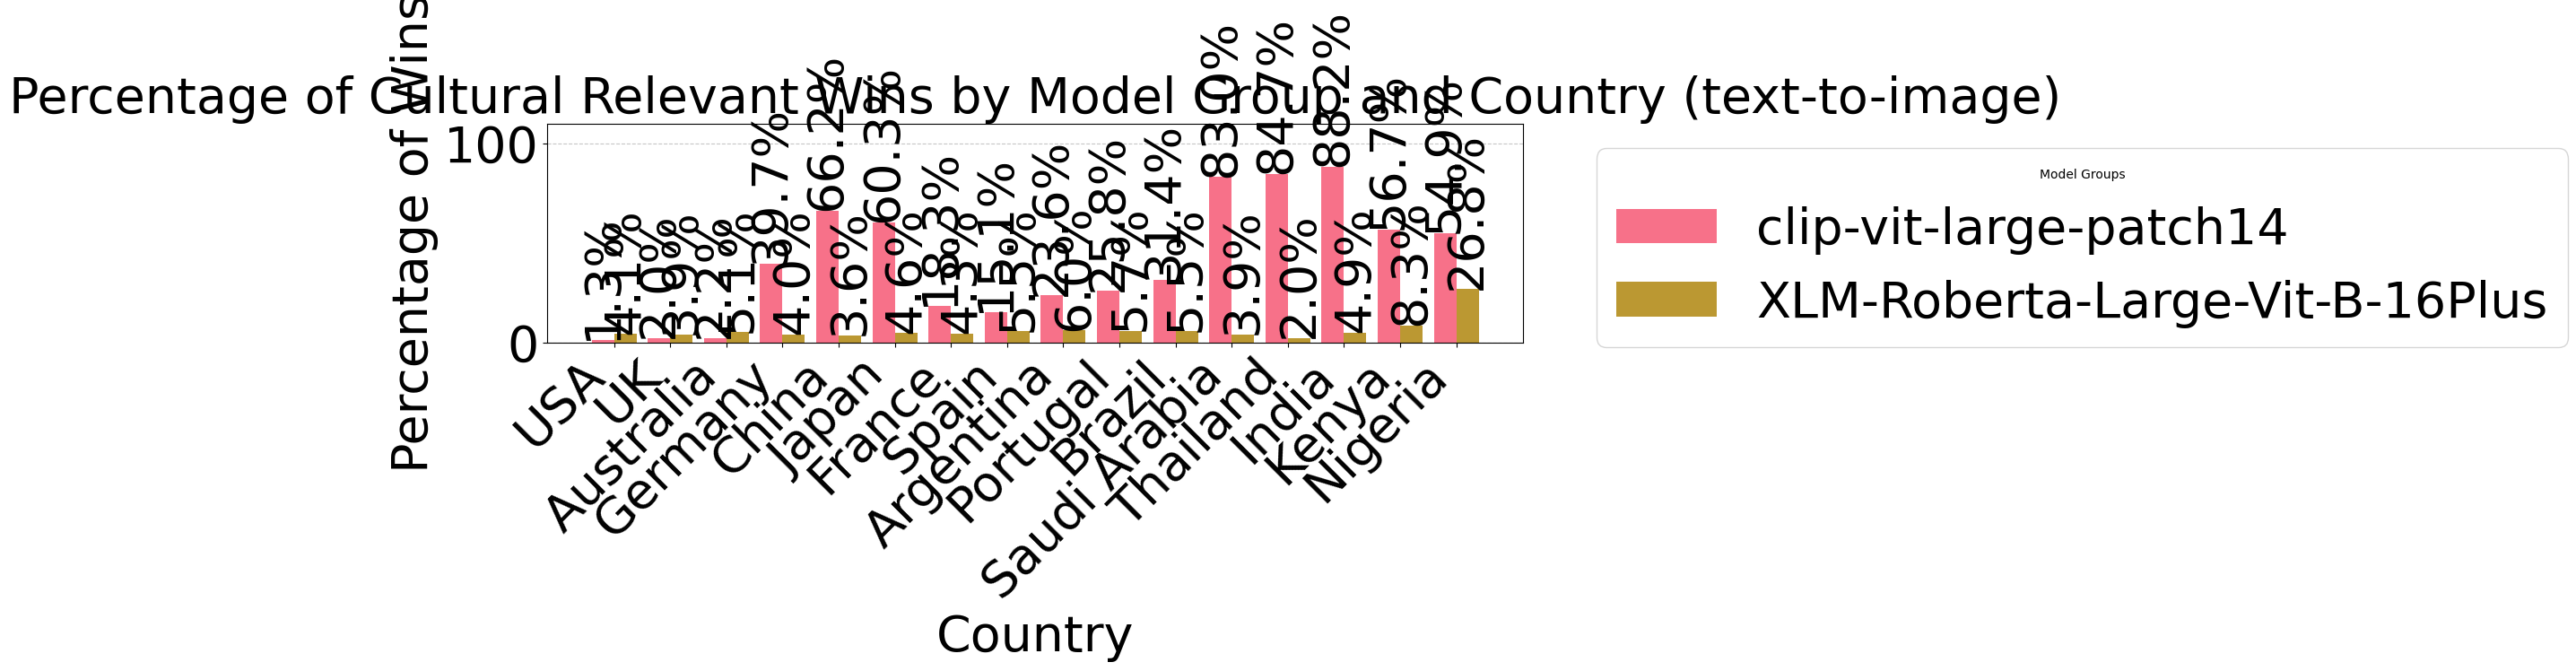

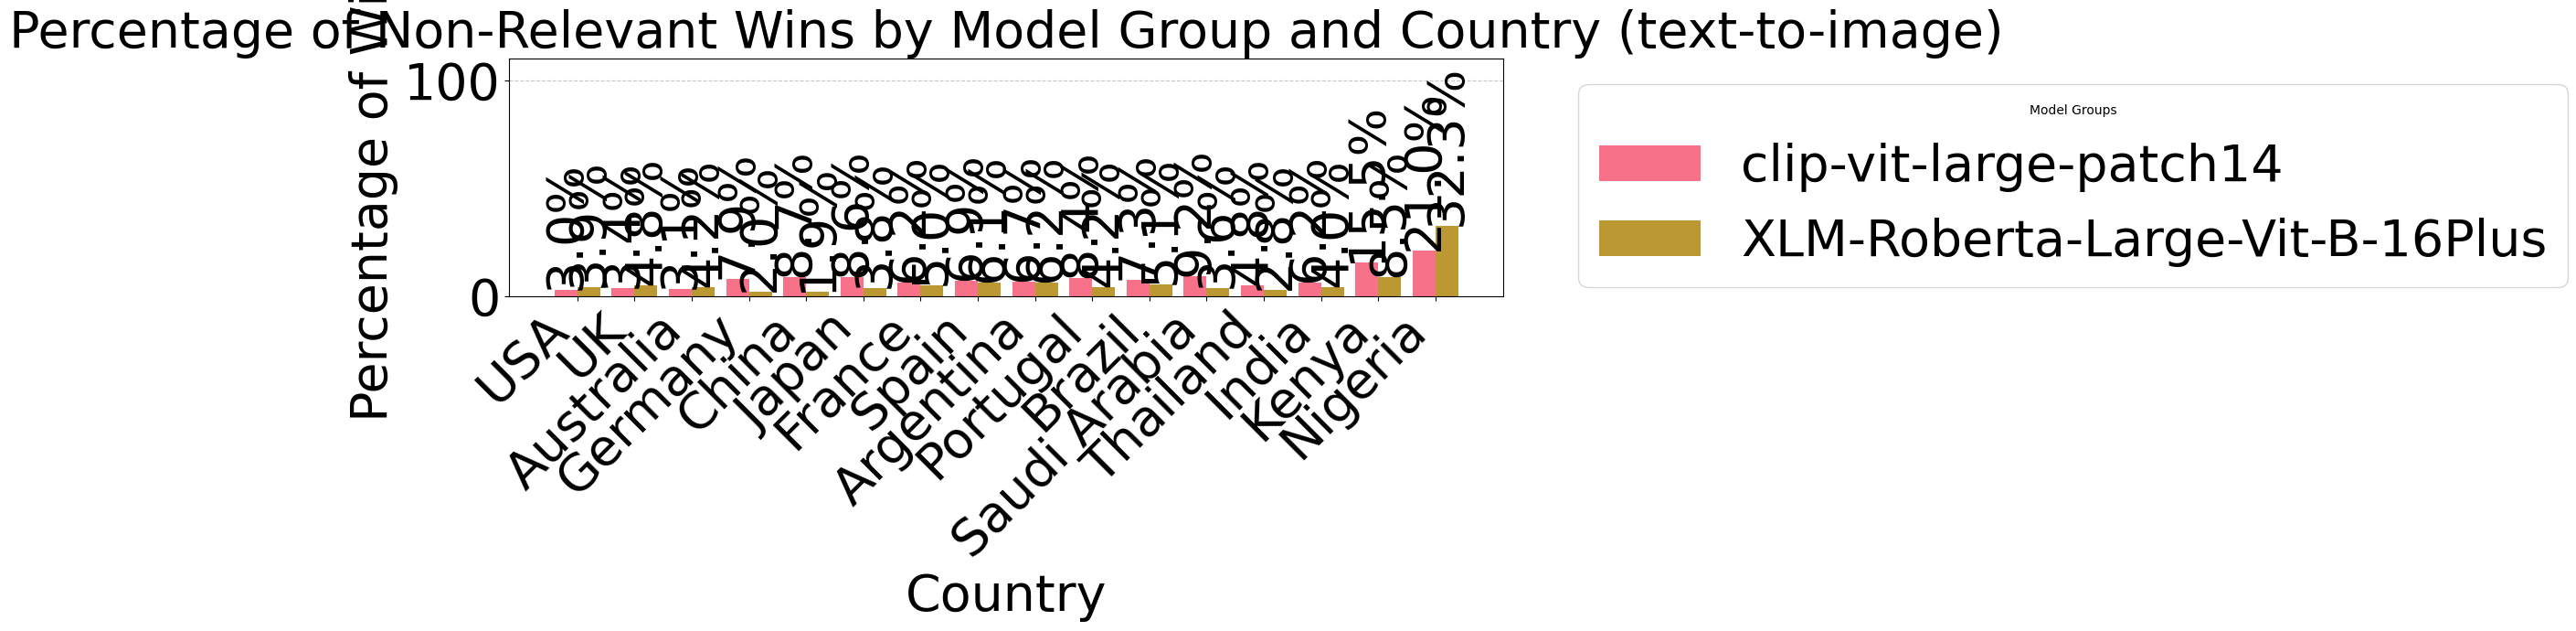

In [ ]:
country_analyzer.plot_wins_grouped_by_model(country_df, ['clip-vit-large-patch14', 'XLM-Roberta-Large-Vit-B-16Plus'], 'text-to-image')